# 3D plots of latent values
This heavily follows the script in 
`xai/experiments/latent_space_3d/generate_plot_script.py` but with alternative plotting

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import torchvision

from xai.constants import MODEL_DIR
from xai.models.simple_cnn import CNNBinaryClassifier3D
from xai.data_handlers.utils import load_training_data_mnist_binary, load_test_data_mnist_binary
from xai.data_handlers.mnist import DEFAULT_MNIST_NORMALIZATION
from xai.evaluation_metrics.distance import SimplexDistance
from xai.experiments.latent_space_distribution.plot_utils import (
    plot_latent_space_2d, plot_latent_shift, get_data_and_labels_for_digits
)



## 1. Gather data

In [3]:
##############
# Load model #
##############
MODEL_FNAME = "binary_cnn_mnist_3d_run_1.pth"
model = CNNBinaryClassifier3D()
model.load(MODEL_DIR / MODEL_FNAME)


#############
# Load data #
#############
BATCH_SIZE = 64

# Source data is used to train simplex model
train_dl, validation_dl = load_training_data_mnist_binary(batch_size=BATCH_SIZE,
                                                          shuffle=False,
                                                          train_validation_split=[0.8, 0.2])
source_data, source_labels = next(iter(train_dl))

# Test data, by original label (digit) rather than boolean, is used for plots
test_dl = load_test_data_mnist_binary(batch_size=BATCH_SIZE,
                                      digits=(0, 1, 2),
                                      count_per_digit={0: 50, 1: 50, 2: 50},
                                      shuffle=False)
test_data = test_dl.dataset.dataset.data
test_data = torchvision.transforms.Normalize(*DEFAULT_MNIST_NORMALIZATION)(test_data / 255)
test_data = test_data[:, None, :, :]  # A 1 dimension went missing somewhere?
labels = test_dl.dataset.dataset.targets

## 2. Filter and reshape for plot

In [64]:
def reshape_latent_tensor_to_df(latents, labels_digits, animation_state=1):
    latent_df = pd.DataFrame(latents, columns=['LatentDim1', 'LatentDim2', 'LatentDim3'])
    latent_df['labels'] = labels_digits
    latent_df['point_size'] = 1
    latent_df['animation_state'] = animation_state
    return latent_df


In [110]:
#########################################
# Plot different digits in latent space #
#########################################
digits = (0, 1, 2)
n = 100

test_data_digits, labels_digits = get_data_and_labels_for_digits(test_data, labels, digits, n)
latents = model.latent_representation(test_data_digits).detach()
latent_df = reshape_latent_tensor_to_df(latents, labels_digits, animation_state=0)

latent_df.tail()

,LatentDim1,LatentDim2,LatentDim3,labels,point_size,animation_state
295,1.523348,0.468967,5.395125,2,1,0
296,6.321573,0.000000,0.000000,2,1,0
297,4.103620,1.422346,3.840779,2,1,0
298,2.509375,0.694768,4.171469,2,1,0
299,0.000000,1.467906,10.942745,2,1,0


## 3. Plot 3D scatter of latent space

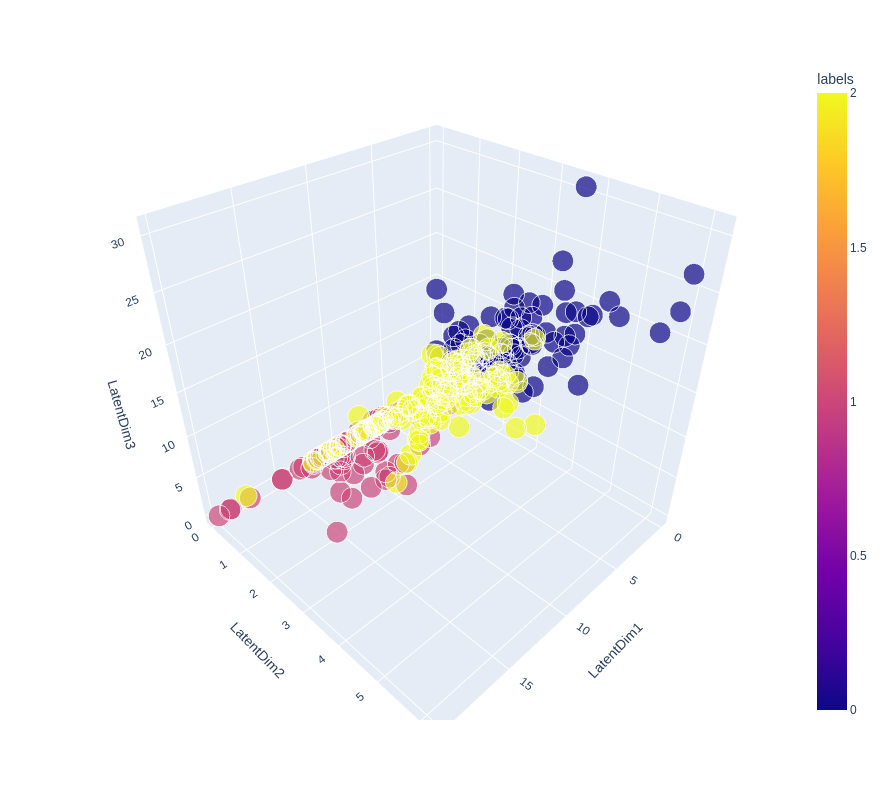

In [111]:
fig = px.scatter_3d(
    latent_df,
    x='LatentDim1',
    y='LatentDim2',
    z='LatentDim3',
    color='labels',
    size='point_size'
)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

## 3. Gather data for residuals

In [57]:
#######################
# Calc residual shift #
#######################
sd = SimplexDistance(model, source_data, test_data_digits)
sd.distance()
latents_approx = sd.simplex.latent_approx()

Weight Fitting Epoch: 2000/10000 ; Error: 3.37e+03 ; Regulator: 222 ; Reg Factor: 0
Weight Fitting Epoch: 4000/10000 ; Error: 1.37e+03 ; Regulator: 162 ; Reg Factor: 0
Weight Fitting Epoch: 6000/10000 ; Error: 942 ; Regulator: 129 ; Reg Factor: 0
Weight Fitting Epoch: 8000/10000 ; Error: 850 ; Regulator: 110 ; Reg Factor: 0
Weight Fitting Epoch: 10000/10000 ; Error: 824 ; Regulator: 102 ; Reg Factor: 0


In [114]:
latent_approx_df = reshape_latent_tensor_to_df(latents_approx, labels_digits, animation_state=16)

Make transition dataframes for sooth transition

In [113]:
def make_midpoint_df(latent_df, latent_approx_df):
    mid_df = latent_df.copy()
    for col in ['LatentDim1', 'LatentDim2', 'LatentDim3', 'animation_state']:
        mid_df[col] = (latent_df[col] + latent_approx_df[col]) / 2
    return mid_df

In [115]:
mid_df = make_midpoint_df(latent_df, latent_approx_df)
quarter_df_left = make_midpoint_df(latent_df, mid_df)
quarter_df_right = make_midpoint_df(mid_df, latent_approx_df)

residual_shift_df = pd.concat(
    [latent_df, quarter_df_left, mid_df, quarter_df_right, latent_approx_df],
    axis=0
)

In [116]:
residual_shift_df

,LatentDim1,LatentDim2,LatentDim3,labels,point_size,animation_state
0,0.000000,1.100815,8.344933,0,1,0.0
1,0.126676,4.074555,18.603399,0,1,0.0
2,0.000000,1.657083,8.511452,0,1,0.0
3,0.000000,1.974178,9.666750,0,1,0.0
4,0.000000,2.221270,11.335234,0,1,0.0
...,...,...,...,...,...,...
295,1.373392,0.975296,6.308346,2,1,16.0
296,3.560334,0.375787,0.239827,2,1,16.0
297,2.007945,0.297804,1.521532,2,1,16.0
298,0.779243,0.250575,2.679021,2,1,16.0


## 4. Plot residuals

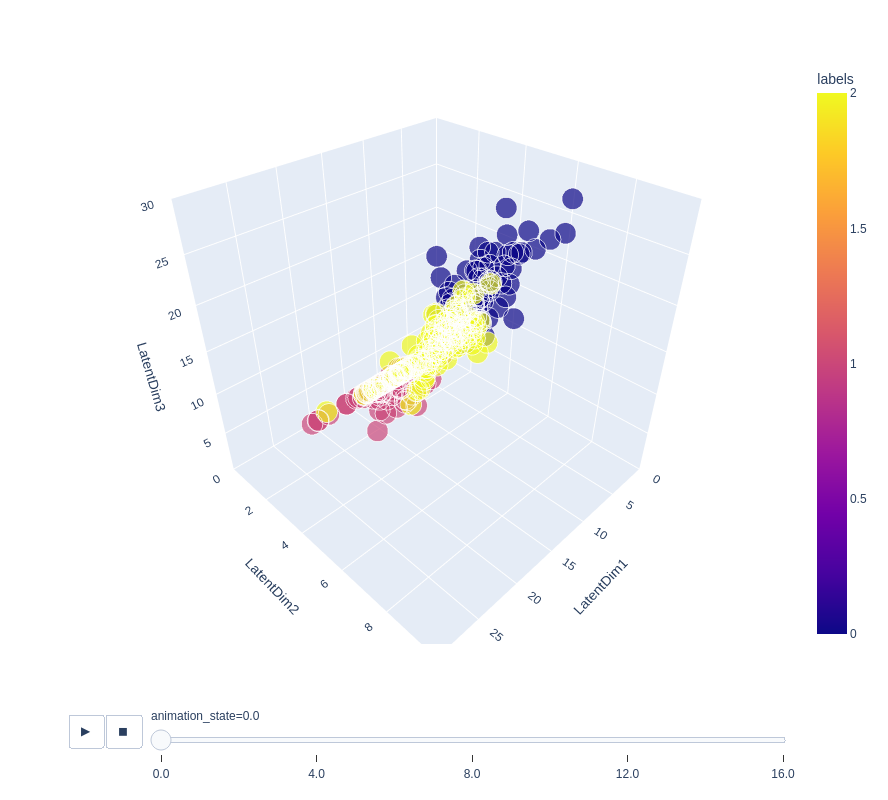

In [118]:
fig = px.scatter_3d(
    residual_shift_df,
    x='LatentDim1',
    y='LatentDim2',
    z='LatentDim3',
    color='labels',
    size='point_size',
    animation_frame='animation_state',
    # animation_group='labels',
    range_x=[0,30],
    range_y=[0,10],
    range_z=[0,30],
)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    # transition = {'duration': 2000, 'easing':'linear', 'ordering':'traces first'}
)
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.show()

In [120]:
fig.write_html('./animated_3d_residual_shift_plot.html')